# IHWP

Vedansh Sharma (12242000) 

## Features

-An Adaptive and Reliable Digital Image Processing Method for Detecting Stop Lines and Correlating Colors to Traffic Light States at Night

-Efficient Extraction of License Plates from Night-Time Traffic Images Using Digital Image Processing Techniques

-License Plate Text Recognition Utilizing PyTesseract OCR

-Dynamic Display of Penalized License Plates on Video Frames

-MySQL Database Integration for Logging License Plate Violations with Fines

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pytesseract
import easyocr
import re
import mysql.connector
import pytesseract
from PIL import Image
from collections import deque
from mysql.connector import Error

In [ ]:
# Database Connection Constants
DB_HOST = 'localhost'
DB_USER = 'root'
DB_PASSWORD = ''
DB_NAME = 'traffic_violation_db'

We used a video from https://www.videvo.net/video/cars-trucksbus-and-taxis-on-the-highway-in-victoria-city/1619206/

# Simulating a traffic light

In [25]:
# import cv2
# import numpy as np

# # Path to the original video
# video_path = 'vids/original_video.mov'
# output_path = 'vids/traffic_video_modified2.mp4'

# # Open the video and get properties
# cap = cv2.VideoCapture(video_path)
# if not cap.isOpened():
#     print("Error: Could not open video file.")
#     exit()

# fps = int(cap.get(cv2.CAP_PROP_FPS))
# frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# print(f"Video Properties - FPS: {fps}, Width: {frame_width}, Height: {frame_height}")

# # Define traffic light rectangle position and dimensions
# # ADJUST THESE BASED ON YOUR SPECIFIC VIDEO RESOLUTION
# rect_x, rect_y = int(frame_width * 0.9), int(frame_height * 0.05)  # Relative positioning
# rect_w, rect_h = 100, 275  # Width and height of the rectangle
# circle_radius = 40         # Increased radius for better visibility

# # Adjusted circle positions relative to rectangle
# circle_positions = [
#     (rect_x + rect_w // 2, rect_y + rect_h // 4),    # Red light position
#     (rect_x + rect_w // 2, rect_y + rect_h // 2),    # Yellow light position
#     (rect_x + rect_w // 2, rect_y + 3 * rect_h // 4)  # Green light position
# ]

# # Traffic light color sequence and timing
# color_sequence = [
#     ('red', (0, 0, 255)),
#     ('yellow', (0, 255, 255)),
#     ('green', (0, 255, 0))
# ]
# color_duration = 10  # seconds per color

# # Define the video writer
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# frame_count = 0
# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# red_light_start_frame = 11 * fps  # Red light starts at 11th second

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Determine the current color based on the frame count
#     if frame_count >= red_light_start_frame:
#         color_index = 0  # Red light from 11th second onward
#     else:
#         cycle_frame = (frame_count // (color_duration * fps)) % 3
#         color_index = int(cycle_frame)

#     # Draw the traffic light rectangle with a thick border
#     cv2.rectangle(frame, (rect_x, rect_y), 
#                   (rect_x + rect_w, rect_y + rect_h), 
#                   (255, 255, 255), 5)  # Increased border thickness

#     # Draw the traffic light circles with thick outlines
#     for i, (_, color) in enumerate(color_sequence):
#         # Determine circle color and thickness
#         if i == color_index:
#             circle_color = color
#             circle_thickness = -1  # Filled circle
#         else:
#             circle_color = (50, 50, 50)  # Dark gray for inactive lights
#             circle_thickness = 3  # Outlined circle

#         cv2.circle(frame, circle_positions[i], circle_radius, 
#                    circle_color, circle_thickness)

#     # Write the modified frame to the output video
#     out.write(frame)
#     frame_count += 1

#     # Optional: Display the video during processing (commented out to prevent potential slowdown)
#     # cv2.imshow('Traffic Light Video', frame)
#     # if cv2.waitKey(1) & 0xFF == ord('q'):
#     #     break

# # Release resources
# cap.release()
# out.release()
# cv2.destroyAllWindows()

# print(f"Video processing complete. Saved to {output_path}")
# print(f"Total frames processed: {frame_count}")

## Light Colour recognition

In this segment, our goal is to identify the color of a traffic light in real-time from a given frame. We took the following steps:

1. Region of Interest: We start by defining a specific area within the image where we expect to find the traffic light. This isolates the relevant portion from the rest of the image, allowing us to focus our analysis.

2. HSV Conversion: The ROI is converted from the RGB color space to HSV (Hue, Saturation, Value). The HSV color model is often preferred for color detection tasks, as it separates chromatic information (hue) from luminance.

3. Defining Color Ranges: We establish the range of hue values that correspond to red and yellow colors. These defined ranges are critical for determining whether the traffic light is showing red, yellow, or green.

4. Creating Color Masks: Using the defined color ranges, we generate masks (binary images) that highlight areas within the ROI where red and yellow colors are detected.

5. Color Detection: We then analyze the masks. If any non-zero values appear in the red mask, we interpret this as the light being red. If the yellow mask contains non-zero values, we identify the light as yellow. If neither red nor yellow is present, we conclude that the light is green.

6. Overlaying Status Information: Finally, we overlay a message on the main image indicating the detected status of the traffic light. This provides a visual cue indicating whether the signal is "Stop," "Caution," or "Go."

The detect_traffic_light_color function facilitates the automatic detection and indication of traffic light colors in real-time, delivering crucial information for subsequent processing, particularly in detecting red-light violations.

In [26]:
import cv2
import numpy as np

def detect_traffic_light_color(frame, bounding_box):
    # Unpack the bounding box dimensions
    x_coord, y_coord, width, height = bounding_box
    # Isolate the region of interest (ROI) from the frame
    region_of_interest = frame[y_coord:y_coord+height, x_coord:x_coord+width]
    
    # Convert the ROI from BGR to HSV color space
    hsv_image = cv2.cvtColor(region_of_interest, cv2.COLOR_BGR2HSV)

    # Set the HSV color range for red traffic lights
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    
    # Set the HSV color range for yellow traffic lights
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Generate binary masks to identify red and yellow colors in the ROI
    mask_red = cv2.inRange(hsv_image, lower_red, upper_red)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    
    # Define text font properties for overlaying information on the frame
    text_font = cv2.FONT_HERSHEY_TRIPLEX
    text_scale = 1  
    text_thickness = 2  
    
    # Determine which color is detected based on the masks
    if cv2.countNonZero(mask_red) > 0:
        display_color = (0, 0, 255)  # Red color for text
        status_message = "Detected Signal Status: Stop"
        detected_color = 'red'
    elif cv2.countNonZero(mask_yellow) > 0:
        display_color = (0, 255, 255)  # Yellow color for text
        status_message = "Detected Signal Status: Caution"
        detected_color = 'yellow'
    else:
        display_color = (0, 255, 0)  # Green color for text
        status_message = "Detected Signal Status: Go"
        detected_color = 'green'
        
    # Overlay the identified traffic light status onto the main frame
    cv2.putText(frame, status_message, (15, 70), text_font, text_scale + 0.5, display_color, text_thickness + 1, cv2.LINE_AA)
    # Draw a separator line
    cv2.putText(frame, '-' * 34, (10, 115), text_font, text_scale, (255, 255, 255), text_thickness, cv2.LINE_AA)
    
    # Return the updated frame and the identified traffic light color
    return frame, detected_color


## Stop line detection

The LineDetector class is designed to detect and highlight stop lines in video frames, adapting the visualization based on traffic light colors (red, yellow, green).

Key Features:
-Initialization: The class uses two queues (y_start_queue and y_end_queue) to store the y-coordinates of the stop line across frames. This helps smooth out fluctuations and provides a consistent representation of the line.

-Color Mapping: A helper function, get_color_code, maps traffic light colors to their BGR equivalents. This allows the detected stop line to be highlighted according to the traffic light status.

-Line Equations: Using given slope and intercept values, the class generates three equations to identify the relevant line segment.

-Creating Masks: Masks are created based on the line equations to focus on the area of interest, reducing distractions from the background.

-Image Processing: The masks are transformed through grayscale conversion, blurring, histogram equalization, and edge detection.

-Hough Line Transform: The Hough Line Transform is applied to detect the stop line based on the processed edges, and the line parameters are stored in the queues.

-Line Drawing & Coloring: The detected line is drawn on the original frame, colored according to the traffic light status by adjusting the frame's color channels.

-Final Mask Creation: A final mask is produced to turn pixels above the detected line black. This mask is essential for isolating vehicles that have crossed the stop line when the light is red.

-The LineDetector class is a vital tool for traffic monitoring and computer vision applications, effectively detecting and visualizing stop lines in video frames.



In [27]:
import numpy as np
import cv2
from collections import deque

class LineDetector:
    def __init__(self, frame_count_avg=10):
        # Initialize deques to keep track of y-coordinates for line positions
        self.start_y_queue = deque(maxlen=frame_count_avg)
        self.end_y_queue = deque(maxlen=frame_count_avg)

    def detect_white_line(self, image, traffic_light_color, 
                         slope1=0.03, intercept1=920, slope2=0.03, intercept2=770, slope3=-0.8, intercept3=2420):

        # Map traffic light colors to BGR format
        def color_mapping(color_name):
            color_dict = {
                'red': (0, 0, 255),
                'green': (0, 255, 0),
                'yellow': (0, 255, 255)
            }
            return color_dict.get(color_name.lower())

        original_frame = image.copy()

        # Define line equations for the areas of interest
        def first_line(x): return slope1 * x + intercept1
        def second_line(x): return slope2 * x + intercept2
        def third_line(x): return slope3 * x + intercept3

        height, width, _ = image.shape
        
        # Create a mask to highlight the area around the stop line
        mask_area1 = image.copy()
        for x in range(width):
            y_value = first_line(x)
            mask_area1[int(y_value):, x] = 0

        mask_area2 = mask_area1.copy()
        for x in range(width):
            y_value = second_line(x)
            mask_area2[:int(y_value), x] = 0

        final_mask = mask_area2.copy()
        for y in range(height):
            x_value = third_line(y)
            final_mask[y, :int(x_value)] = 0

        # Convert the mask to grayscale and apply filters
        gray_mask = cv2.cvtColor(final_mask, cv2.COLOR_BGR2GRAY)
        blurred_mask = cv2.GaussianBlur(gray_mask, (7, 7), 0)

        # Use CLAHE to enhance the image
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_mask = clahe.apply(blurred_mask)

        # Perform edge detection
        detected_edges = cv2.Canny(gray_mask, 30, 100)

        # Close gaps in edges using dilation and erosion
        dilated_edges = cv2.dilate(detected_edges, None, iterations=1)
        cleaned_edges = cv2.erode(dilated_edges, None, iterations=1)

        # Detect lines using Hough Transform
        detected_lines = cv2.HoughLinesP(cleaned_edges, 1, np.pi/180, 100, minLineLength=160, maxLineGap=5)

        # Initialize x-coordinates for line start and end
        x_start = 0
        x_end = width - 1

        if detected_lines is not None:
            for line in detected_lines:
                x1, y1, x2, y2 = line[0]

                # Calculate line slope and intercept
                line_slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)  # Avoid division by zero
                line_intercept = y1 - line_slope * x1

                # Determine y-coordinates based on the line equations
                y_start = int(line_slope * x_start + line_intercept)
                y_end = int(line_slope * x_end + line_intercept)

                # Store y-coordinates in queues for averaging
                self.start_y_queue.append(y_start)
                self.end_y_queue.append(y_end)

        # Compute average y-coordinates for the stop line
        avg_y_start = int(sum(self.start_y_queue) / len(self.start_y_queue)) if self.start_y_queue else 0
        avg_y_end = int(sum(self.end_y_queue) / len(self.end_y_queue)) if self.end_y_queue else 0

        # Adjust line position for drawing
        line_start_offset = 0.32
        adjusted_x_start = x_start + int(line_start_offset * (x_end - x_start))
        adjusted_y_start = avg_y_start + int(line_start_offset * (avg_y_end - avg_y_start))

        # Create a mask for drawing the detected line
        draw_mask = np.zeros_like(image)

        # Draw the stop line on the mask
        cv2.line(draw_mask, (adjusted_x_start, adjusted_y_start), (x_end, avg_y_end), (255, 255, 255), 4)

        # Determine which color channels to modify based on the traffic light color
        color_code = color_mapping(traffic_light_color)
        if color_code == (0, 255, 0):  # Green
            channel_indices = [1]
        elif color_code == (0, 0, 255):  # Red
            channel_indices = [2]
        elif color_code == (0, 255, 255):  # Yellow
            channel_indices = [1, 2]  # Modify both green and red channels
        else:
            raise ValueError('Unsupported color')

        # Change the specified color channels in the original frame where the mask is white
        for channel_index in channel_indices:
            image[draw_mask[:,:,channel_index] == 255, channel_index] = 255

        # Calculate average slope and intercept for the stop line
        avg_slope = (avg_y_end - avg_y_start) / (x_end - x_start + np.finfo(float).eps)
        avg_intercept = avg_y_start - avg_slope * x_start

        # Create a mask to highlight the area above the stop line
        above_line_mask = np.copy(original_frame)
        for x in range(width):
            y_value = avg_slope * x + avg_intercept - 35
            above_line_mask[:int(y_value), x] = 0  # Set pixels above the line to black

        return image, above_line_mask


## License Plate Extraction

The extract_license_plate function is organized into several essential phases to detect and extract license plates from a given frame. Here’s a breakdown of the process:

Preprocessing: The function begins with crucial preprocessing steps, including converting the image to grayscale to work with single-channel intensity values. It applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance the image contrast by equalizing the histogram. To reduce noise and prepare for more precise detection, erosion is also performed.

Isolating and Cropping the Region of Interest (ROI): Utilizing a mask from earlier steps, where pixels above the stop line are rendered black, the code identifies the non-black pixels that indicate the road area beneath the stop line. A bounding box is calculated around this region, and a portion on the left side, belonging to the opposite lane, is excluded. This refined cropped region becomes the primary ROI for detecting license plates, as the Haar cascade classifier operates more effectively on smaller, well-defined areas.

Haar Cascade Classifier: The cropped grayscale image is then processed using a Haar cascade classifier, a traditional non-deep learning approach proficient in pattern recognition. This classifier has been pre-trained to identify license plate patterns, returning the locations of possible license plates as rectangles.

Extracting License Plates & Final Output: The function marks the detected license plates on the original frame with rectangles. Additionally, the potential license plates are cropped from the grayscale image and stored in a list. The function concludes by returning the original frame with the bounded license plates and the list of detected license plates.

Overall, extract_license_plate is a well-structured and efficient function crucial for applications that require license plate recognition. It utilizes classic computer vision methods to effectively extract valuable information.



In [28]:
def extract_license_plate(frame, mask_line):
    # print(mask_line)
    # return
    # Convert the frame to grayscale, as Haar cascades typically operate on single-channel images
    gray_image = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)
    
    # Utilize CLAHE for histogram equalization to enhance image contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray_image)
    
    # Apply erosion with a 2x2 kernel to minimize noise in the image
    erosion_kernel = np.ones((2, 2), np.uint8)
    processed_gray = cv2.erode(enhanced_gray, erosion_kernel, iterations=1)

    # Identify the bounding box around non-black pixels
    non_black_area = cv2.findNonZero(processed_gray)
    x, y, width, height = cv2.boundingRect(non_black_area)

    # Adjust the width of the bounding box by excluding 30% from the right side
    adjusted_width = int(width * 0.7)

    # Crop the grayscale image to the identified bounding box
    cropped_gray_image = processed_gray[y:y + height, x:x + adjusted_width]

    # Use the Haar cascade classifier to detect license plates in the cropped image
    detected_license_plates = license_plate_cascade.detectMultiScale(cropped_gray_image, scaleFactor=1.07, minNeighbors=15, minSize=(20, 20))

    # Initialize a list to store cropped license plate images
    extracted_license_plate_images = []

    # Iterate over detected license plates
    for (plate_x, plate_y, plate_width, plate_height) in detected_license_plates:
        # Draw rectangles around the detected license plates in the original frame
        cv2.rectangle(frame, (plate_x + x, plate_y + y), (plate_x + x + plate_width, plate_y + y + plate_height), (0, 255, 0), 3)
        
        # Crop the detected license plate from the grayscale image and add it to the list
        license_plate_crop = cropped_gray_image[plate_y:plate_y + plate_height, plate_x:plate_x + plate_width]
        extracted_license_plate_images.append(license_plate_crop)

    return frame, extracted_license_plate_images


## Recognising test on License plates

The apply_ocr_to_image function is designed to recognize and extract text, such as numbers and letters, from license plate images using PyTesseract OCR. Here’s a simple overview of how it works:

Image Thresholding: The function converts the image into a black-and-white format. This helps to separate the text from the background, making the text on the license plate black and the background white.

Format Conversion: Since PyTesseract needs images in the PIL Image format, the function converts the thresholded image (which is in OpenCV format) into a format that PyTesseract can use.

Text Extraction: The function uses PyTesseract to pull out text from the converted image. It uses a special setting (--psm 6) to help the OCR recognize text that is spread out, which is common for license plates.

Text Cleanup: After extracting the text, the function removes any extra spaces at the beginning or end of the recognized text, ensuring that the result is clean and neat.

With the apply_ocr_to_image function, it becomes easier to extract text from license plate images, making use of traditional methods for optical character recognition.

In [29]:
def apply_ocr_to_image(license_plate_image):    
    # Apply thresholding to convert the image to binary
    _, binary_image = cv2.threshold(license_plate_image, 120, 255, cv2.THRESH_BINARY)

    # Convert the binary image from OpenCV format to PIL format
    pil_image = Image.fromarray(binary_image)

    # Extract text from the image using PyTesseract with a specified configuration
    extracted_text = pytesseract.image_to_string(pil_image, config='--psm 6')

    # Return the extracted text with leading and trailing whitespace removed
    return extracted_text.strip()


## Displaying Penalised License Plates

The draw_penalized_text function is skillfully designed to display penalized license plates on video frames. This dynamic feature ensures that each fined license plate appears in the order it was identified. Whether the source is recorded footage or live monitoring, the list of penalized plates is continuously updated on the car monitoring display.

With this function, users can effortlessly track and view penalized license plates in real-time on their vehicle monitoring screens, making it an essential component for any traffic management or vehicle oversight system.

In [30]:
def display_penalized_license_plates(frame):
    # Define the font style, scale, thickness, and color
    font_style = cv2.FONT_HERSHEY_TRIPLEX
    scale = 1  
    thickness = 2
    text_color = (255, 255, 255)  # White

    # Starting Y-coordinate for text placement
    y_coordinate = 180
    
    # Draw the title on the frame
    cv2.putText(frame, 'Fined License Plates:', (25, y_coordinate), font_style, scale, text_color, thickness)
    
    # Increment the Y-coordinate for the next line
    y_coordinate += 80

    # Iterate through the list of penalized license plates
    for license_plate in penalized_texts:
        # Display each penalized license plate on the frame
        cv2.putText(frame, '->  ' + license_plate, (40, y_coordinate), font_style, scale, text_color, thickness)
        
        # Update the Y-coordinate for the next license plate entry
        y_coordinate += 60


## Store fined License Plates in MySQL

In this section, I will outline a series of functions designed to seamlessly integrate with a MySQL database for the effective recording of fined license plates. These functions provide capabilities for creating, updating, viewing, and deleting license plate data as required. Here’s a detailed overview of the functions:

Together, these functions facilitate efficient management of license plate violations, ensuring both data integrity and accessibility. Since some functions are optional, developers can selectively implement those that best suit their application's requirements.

Database and Table Initialization (create_database_and_table):
Connects to MySQL using the specified credentials.
Creates a new database if it isn't already present and selects it for subsequent operations.
Sets up a table named license_plates to store records of each license plate along with their associated violation counts.
It's important to mention that this function may be optional after the initial database setup, as there’s no need to repeatedly recreate the structure.

In [31]:
def create_database_and_table(host, user, password, database):
    try:
        # Establish a connection to the MySQL server
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password
        )
        
        if connection.is_connected():
            # Create a cursor to execute SQL commands
            cursor = connection.cursor()

            # Create a database if it doesn't already exist
            cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database}")
            print(f"Successfully created database: {database}!")

            # Select the newly created database for use
            cursor.execute(f"USE {database}")

            # Define a new table structure
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS license_plates (
                    id INT AUTO_INCREMENT PRIMARY KEY,
                    plate_number VARCHAR(255) NOT NULL UNIQUE,
                    violation_count INT DEFAULT 1
                )
            """)
            print("Successfully created the table!")

            cursor.close()

    except Error as e:
        print("MySQL connection error:", e)

    finally:
        if connection.is_connected():
            connection.close()


2.Recording Violations: ( `update_database_with_violation` ):
- Connects to the specified MySQL database.
- Checks if a particular license plate already exists in the database.
- If the license plate exists, its violation count is incremented. If it doesn't, a new record for the license plate is added with a default violation count of 1.

In [32]:
def update_database_with_violation(plate_number, host, user, password, database):
    try:
        # Establish a connection to the MySQL database
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        
        if connection.is_connected():
            cursor = connection.cursor()

            # Query to check for existing license plate records
            cursor.execute(f"SELECT violation_count FROM license_plates WHERE plate_number = %s", (plate_number,))
            result = cursor.fetchone()
            
            if result:
                # If the plate number is found, update the violation count
                cursor.execute(f"UPDATE license_plates SET violation_count = violation_count + 1 WHERE plate_number = %s", (plate_number,))
            else:
                # If not found, add a new entry for the license plate
                cursor.execute(f"INSERT INTO license_plates (plate_number) VALUES (%s)", (plate_number,))
            
            connection.commit()
            cursor.close()

    except Error as e:
        print("An error occurred while connecting to MySQL:", e)

    finally:
        if connection.is_connected():
            connection.close()


3.Viewing All Violations: 
- Fetches and displays all the recorded license plate violations, ordered by the number of violations.
- This function serves as an optional utility for users/admins who wish to view a snapshot of all violations. While it might not be necessary for all use cases, it provides a quick glance at the data.

In [33]:
def print_all_violations(host, user, password, database):
    try:
        # Establish a connection to the MySQL database
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        
        if connection.is_connected():
            cursor = connection.cursor()

            # Execute a query to retrieve all traffic violations from the database
            cursor.execute("SELECT plate_number, violation_count FROM license_plates ORDER BY violation_count DESC")
            records = cursor.fetchall()
            
            print("\n")
            print("-" * 66)
            print("\nList of All Traffic Violations in the Database:\n")
            for plate_number, violation_count in records:
                print(f"Plate Number: {plate_number}, Violations: {violation_count}")
            
            cursor.close()

    except Error as e:
        print("An error occurred while connecting to MySQL:", e)

    finally:
        if connection.is_connected():
            connection.close()


4.Clearing Recorded Data:
- Deletes all the records in the `license_plates` table, effectively resetting the database.
- This function is also optional and can be seen as a tool for data management or debugging purposes. Routine operations might not require its use.

In [34]:
def clear_license_plates(host, user, password, database):
    try:
        # Connect to the MySQL database
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        
        if connection.is_connected():
            cursor = connection.cursor()

            # Execute a command to remove all entries from the license plates table
            cursor.execute("DELETE FROM license_plates")

            # Commit the changes to the database
            connection.commit()
            cursor.close()

    except Error as e:
        print("An error occurred while connecting to MySQL:", e)

    finally:
        if connection.is_connected():
            connection.close()


## Execution

Finally, I will outline the main function, which orchestrates the entire process of detecting traffic violations from a video feed. This function analyzes an offline traffic video, identifies license plates of vehicles that cross the line when the traffic light is red, and processes any violations. Here’s a detailed overview of its operations:

Database Initialization: The function starts by ensuring the necessary database and table for storing license plate violations are set up.

Processing Video Feed: It reads the offline video file traffic_video.mp4, examining each frame to identify any traffic violations.

Traffic Light Detection: The color of the traffic light in the current frame is determined using the detect_traffic_light_color function.

Stop Line Detection: The function utilizes the LineDetector class to locate the white stop line on the road, marking it based on the identified traffic light color.

Violation Detection and Processing: If the traffic light is red, the program calls the extract_license_plate and apply_ocr_to_image functions to identify vehicles that cross the white line and to read their license plates. Given the potential for low-quality images fed to the OCR function, some readings may be inaccurate. To mitigate this, detected plates are checked against a predefined format, ensuring they conform to the standard license plate design. Only plates that match this format and haven't been recorded previously are logged as violations.

Updating the Database: The identified license plates are recorded in the database. If a plate has already been flagged for a violation, its count is increased.

Displaying Updates: The draw_penalized_text function is invoked to show the penalized license plates in order on the video frame.

Process Termination: The function continues processing until the video ends or the user interrupts with the ESC key. Afterward, the video feed is released, and all graphical user interface (GUI) windows are closed.

Generating Reports: Finally, the function retrieves and displays all violations from the database, offering a summary of all offenses recorded during the video playback.

This comprehensive approach makes the main function a powerful tool for monitoring and documenting traffic violations from video sources, highlighting its importance in traffic enforcement and analysis.

In [35]:
clear_license_plates(DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)

In [36]:
def main():
    # Ensure the database and table are set up
    create_database_and_table(DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)

    # Clear any existing license plate records from the previous run. (Comment out this line if not needed!)
    clear_license_plates(DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)

    # Open the traffic video file
    
    vid = cv2.VideoCapture('traffic_video_modified.mp4')
    
    # Instantiate the line detector
    detector = LineDetector()

    # frame_width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))

    # Process each frame in the video
    while True:
        # Capture the current frame
        ret, frame = vid.read()
        
        # Exit the loop if no frame is returned
        if not ret:
            break

        # Define the rectangle for traffic light detection
        rect = (1700, 40, 100, 250) 
        # rect = (frame_width - 150, 40, 100, 250)

        
        # Determine the color of the traffic light
        frame, color = detect_traffic_light_color(frame, rect)
        
        # Identify the white stop line
        frame, mask_line = detector.detect_white_line(frame, color)
        
        # Check for violations if the light is red
        if color == 'red':
            # Extract the license plate from the frame
            frame, license_plate_images = extract_license_plate(frame, mask_line)
            
            # Iterate through each detected license plate
            for license_plate_image in license_plate_images:
                # Use OCR to read the license plate image
                text = apply_ocr_to_image(license_plate_image)
                
                # Validate the detected text format and ensure it hasn't been recorded yet
                if text is not None and re.match("^[A-Z]{2}\s[0-9]{3,4}$", text) and text not in penalized_texts:
                    penalized_texts.append(text)
                    print(f"\nFined license plate: {text}")

                    # Display the license plate image
                    plt.figure()
                    plt.imshow(license_plate_image, cmap='gray')
                    plt.axis('off')
                    plt.show()
                    
                    # Log the license plate violation in the database
                    update_database_with_violation(text, DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)
        
        # Render penalized texts on the frame if any exist
        if penalized_texts:
            display_penalized_license_plates(frame)

        # Show the processed frame
        cv2.imshow('frame', frame)

        # Exit if the ESC key is pressed
        if cv2.waitKey(1) == 27:
            break

    # Release the video capture object
    vid.release()
    
    # Close all OpenCV windows
    cv2.destroyAllWindows()

    # Retrieve and print all recorded violations from the database
    print_all_violations(DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)


Before we begin with the main functionalities of our program, there are a few essential setup steps to consider:

Haar Cascade Initialization: Central to our license plate detection system is the Haar cascade classifier, which uses a pre-trained model called haarcascade_russian_plate_number.xml. This model is specifically designed to identify license plates within video frames. Importantly, we instantiate the Haar cascade object outside of its related function to improve efficiency. Loading this object from the configuration file can be a slow process, so by defining it here, we ensure that our program runs smoothly without unnecessary delays during license plate detection.

List Creation: We also create a list named penalized_texts, which will serve as a storage container for the license plate texts of vehicles that have committed traffic violations. This list is defined globally, allowing both the main function and the draw_penalized_text function to easily access and update its contents as needed.

In [37]:
%%capture
# Load the trained Haar Cascade
license_plate_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')

# Create a list to store unique penalized license plate texts
penalized_texts = []

Successfully created database: traffic_violation_db!
Successfully created the table!

Fined license plate: YB 6433


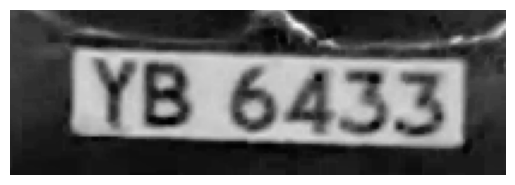


Fined license plate: NN 773


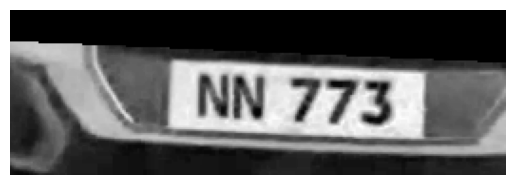



------------------------------------------------------------------

List of All Traffic Violations in the Database:

Plate Number: YB 6433, Violations: 1
Plate Number: NN 773, Violations: 1


In [38]:
if __name__ == "__main__":
    main()  

In [ ]:
import mysql.connector
from huggingface_hub import InferenceClient

# Database connection constants
DB_HOST = 'localhost'
DB_USER = 'root'
DB_PASSWORD = ''
DB_NAME = 'traffic_violation_db'

# Initialize the InferenceClient with your API key
client = InferenceClient(api_key="------------------")

# System message to set the model's behavior to SQL query generation
messages = [
    {
        "role": "system",
        "content": "You are an assistant that generates SQL queries based on user input. Respond with the exact SQL query that solves the user's task. The name of the table is license_plates. Output just the answer."
    },
    {
        "role": "user",
        "content": "Show all the entries in the table"
    }
]

# Get the SQL query from Hugging Face model
completion = client.chat.completions.create(
    model="mistralai/Mistral-7B-Instruct-v0.3", 
    messages=messages, 
    max_tokens=500
)

# Extract the SQL query from the response
sql_query = completion.choices[0].message['content']

# Connect to the MySQL database and execute the query
try:
    # Establish a connection to the database
    connection = mysql.connector.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_NAME
    )
    
    cursor = connection.cursor()
    
    # Execute the SQL query
    cursor.execute(sql_query)
    
    # Fetch all the results
    results = cursor.fetchall()
    
    # Print the results
    for row in results:
        print(row)
    
except mysql.connector.Error as err:
    print(f"Error: {err}")
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()


(21, 'YB 6433', 1)
(22, 'NN 773', 1)


/home/vedansh/.local/lib/python3.10/site-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'ChatCompletionOutputMessage' values through dict is deprecated and will be removed from version '0.25'. Use dataclass attributes instead.
  warnings.warn(
